## Step 1: Download images of birds and non-birds

In [1]:
# If not inslalled, pip install fastai and duckduckgo_search

# First we needs to define the search_images function

from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [2]:
# Then we can search for images

urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://2.bp.blogspot.com/-LZ4VixDdVoE/Tq0ZhPycLsI/AAAAAAAADDM/OKyayfW-z4U/s1600/beautiful_Birds_wallpapers_pictures_Kingfisher_Lilac+Breasted+Roller+Bird.JPG'

/Users/ondrej.drapalik/opt/anaconda3/envs/fastai-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


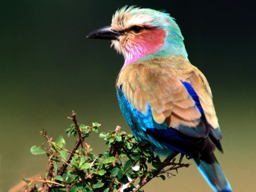

In [3]:
# Use download_url to get the image and fastai to display it
from fastdownload import download_url

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


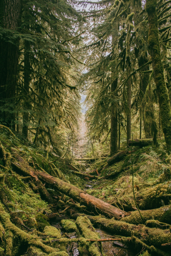

In [4]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [5]:
from time import sleep

searches = 'forest','bird'

path = Path('images/bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model

In [6]:
# Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

### DataLoader and DataBlock

This code is defining a `DataLoader` object in the fastai library. The `DataLoader` is an object that loads and manages a dataset for training and evaluation of a machine learning model. The `DataLoader` is created using a `DataBlock`, which defines the rules for preprocessing and splitting the data into training, validation, and possibly test sets.

The `DataBlock` is being initialized with the following arguments:

- `blocks`: This specifies the types of blocks that the `DataBlock` should use. In this case, there are two blocks: `ImageBlock` and `CategoryBlock`. The `ImageBlock` is used to load and preprocess images, and the `CategoryBlock` is used to handle the categorical labels associated with the images.

- `get_items`: This is a function that returns the list of items (in this case, file paths to images) that the `DataBlock` should use. The `get_image_files` function is provided as the `get_items` argument.

- `splitter`: This is an object that defines how the data should be split into training, validation, and possibly test sets. In this case, the `RandomSplitter` is being used to split the data randomly, with 20% of the data being used for validation (`valid_pct=0.2`). The `seed` argument ensures that the same split is used each time the code is run.

- `get_y`: This is a function that takes an item (in this case, a file path to an image) and returns the corresponding label for that item. The `parent_label` function is provided as the `get_y` argument.

- `item_tfms`: This is a list of transformations that should be applied to the items (in this case, the images) during preprocessing. In this case, a single transformation is being applied: `Resize(192, method='squish')`. This will resize the images to have a height of 192 pixels, while preserving the aspect ratio. The `squish` method will stretch the image to fit the specified dimensions while preserving the aspect ratio, which may cause the image to appear distorted.

Finally, the `dataloaders` method is called on the `DataBlock` object, with `path` and `bs=32` as arguments. The `path` argument specifies the root directory for the dataset, and the `bs` argument specifies the batch size for the `DataLoader`. The `dataloaders` method creates a `DataLoader` object and returns it.

The `show_batch` method is then called on the `DataLoader` object, with `max_n=6` as an argument. This method displays a batch of data from the `DataLoader`, with a maximum of 6 items per batch. This can be useful for visualizing the data and checking that it has been loaded and preprocessed correctly.


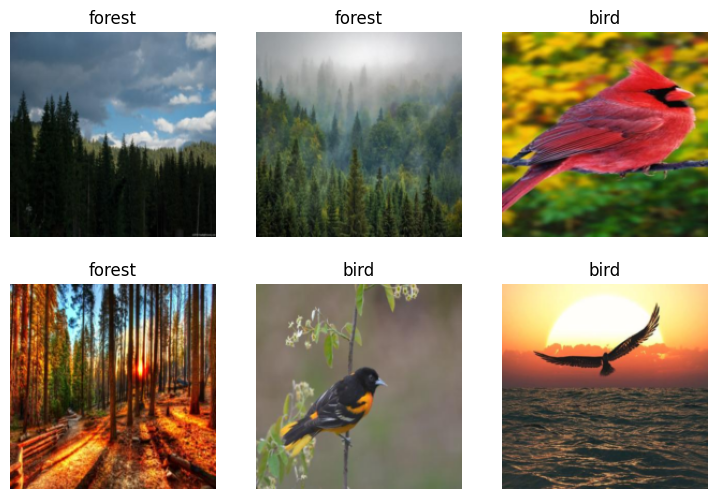

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [19]:
# We'll use a pretrained ResNet18

learn = vision_learner(dls, resnet18, metrics=error_rate)

# Take pretrained weights from the model and train it on our particular dataset for 3 epochs
learn.fine_tune(3)

/Users/ondrej.drapalik/opt/anaconda3/envs/fastai-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ondrej.drapalik/opt/anaconda3/envs/fastai-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.638715,0.110169,0.045455,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.044097,0.001333,0.000000,00:27
1,0.022936,0.000206,0.000000,00:27
2,0.015090,0.000133,0.000000,00:28


## Step 3: Use our model

### What does the first line do?

The predict method returns a tuple containing three elements:

- A string indicating the predicted class of the input image
- An integer representing the index of the predicted class
- An array of probabilities for each possible class, where the probability at index i corresponds to the class at index i.

The first element of the tuple, is_bird, is assigned the predicted class of the input image. The second and third elements are not used in this code and are assigned to _, a placeholder for values that will be discarded.

The code then prints out a string stating the predicted class of the input image and the probability that the image is a bird. The probability is obtained by accessing the first element of the probs array and formatting it to 4 decimal places using the :.4f string formatting syntax.

In [21]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
